In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io, plot
from cellpose.io import imread
from skimage.io import imsave

io.logger_setup()

2025-05-01 10:21:40,262 [INFO] WRITING LOG OUTPUT TO /home/donald/.cellpose/run.log
2025-05-01 10:21:40,262 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.6.0


(<Logger cellpose.io (INFO)>, PosixPath('/home/donald/.cellpose/run.log'))

In [ ]:
# USER INPUTS
# Paths
pth_imgs = r'/home/donald/Desktop/donald/data/LC_CODA/Br5417/tif_2_5x'                     # path to input directory with the images to crop
pth_masks = r'/home/donald/Desktop/donald/data/LC_CODA/Br5417/cropped/new_tif_2_5x'        # path to output directory for cropped downscaled masks
pth_overlaid = os.path.join(pth_masks, 'overlaid_masks')                                   # path to output directory for cropped downscaled overlaid masks

# Input parameters
img_exts = (".tif", ".tiff") # tuple containing valid image extensions

# Downscale factor (Aim for less than 150 px cell diameter for higher accuracy and speed for cellpose)
downscale_factor = 1 / 20

# Visualize n images and apply to these first
n = 5

# Cellpose parameters
model_type = "cyto3"
channels = [0,0]            # first and second channels (grayscale=0, R=1, G=2, B=3)
diameter = 135              # cell diameter in pixels (most important to adjust)
cellprob_threshold = -1     # set lower to increase boundary and higher to decrease boundary (range is -6 to 6)

In [4]:
# Create paths if they don't exist
os.makedirs(pth_masks, exist_ok=True)
os.makedirs(pth_overlaid, exist_ok=True)

In [12]:
# Read images
img_files = [os.path.join(pth_imgs, f) for f in os.listdir(pth_imgs) if f.lower().endswith(img_exts)]
img_names = [os.path.basename(f) for f in img_files]

# read & downscale one at a time
imgs = []
for i, fp in enumerate(img_files):
    print(f'{i}/{len(img_files)}...')
    img = imread(fp)
    img_ds = cv2.resize(
        img,
        (0, 0),
        fx=downscale_factor,
        fy=downscale_factor,
        interpolation=cv2.INTER_AREA
    )
    imgs.append(img_ds)

print(f"Found {len(imgs)} images")
print(f"Downscaled image shape: {imgs[0].shape}")

0/118...
1/118...
2/118...
3/118...
4/118...
5/118...
6/118...
7/118...
8/118...
9/118...
10/118...
11/118...
12/118...
13/118...
14/118...
15/118...
16/118...
17/118...
18/118...
19/118...
20/118...
21/118...
22/118...
23/118...
24/118...
25/118...
26/118...
27/118...
28/118...
29/118...
30/118...
31/118...
32/118...
33/118...
34/118...
35/118...
36/118...
37/118...
38/118...
39/118...
40/118...
41/118...
42/118...
43/118...
44/118...
45/118...
46/118...
47/118...
48/118...
49/118...
50/118...
51/118...
52/118...
53/118...
54/118...
55/118...
56/118...
57/118...
58/118...
59/118...
60/118...
61/118...
62/118...
63/118...
64/118...
65/118...
66/118...
67/118...
68/118...
69/118...
70/118...
71/118...
72/118...
73/118...
74/118...
75/118...
76/118...
77/118...
78/118...
79/118...
80/118...
81/118...
82/118...
83/118...
84/118...
85/118...
86/118...
87/118...
88/118...
89/118...
90/118...
91/118...
92/118...
93/118...
94/118...
95/118...
96/118...
97/118...
98/118...
99/118...
100/118...

In [17]:
# Configure model
model = models.Cellpose(model_type=model_type, gpu=True)

2025-05-01 10:29:39,172 [INFO] ** TORCH CUDA version installed and working. **
2025-05-01 10:29:39,173 [INFO] >>>> using GPU (CUDA)
2025-05-01 10:29:39,173 [INFO] >> cyto3 << model set to be used
2025-05-01 10:29:39,199 [INFO] >>>> loading model /home/donald/.cellpose/models/cyto3
2025-05-01 10:29:39,229 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


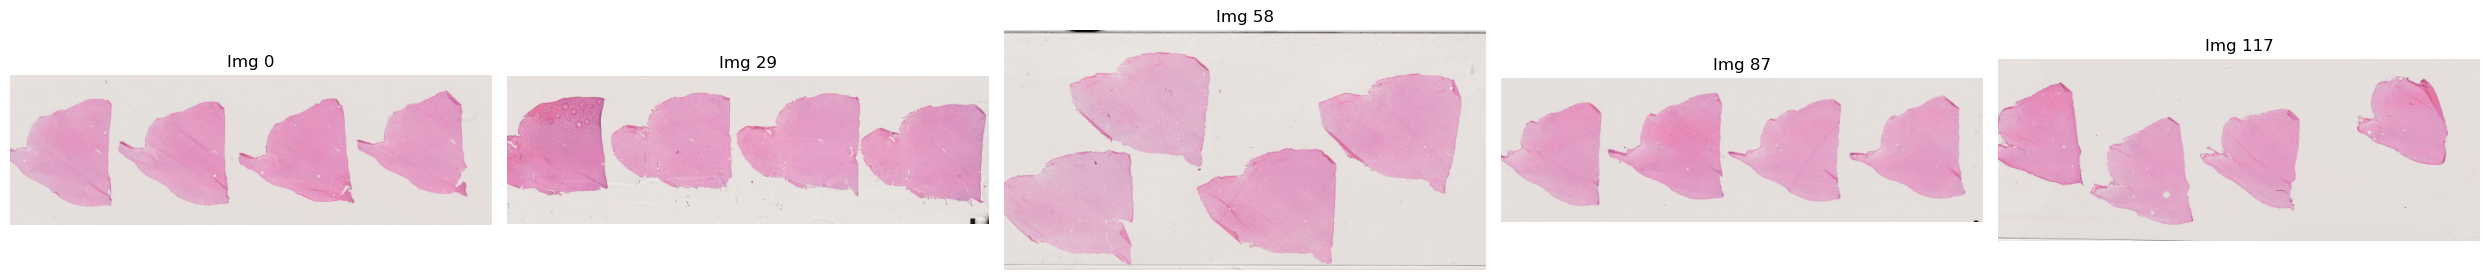

2025-05-01 10:30:26,891 [INFO] channels set to [0, 0]
2025-05-01 10:30:26,892 [INFO] ~~~ FINDING MASKS ~~~
2025-05-01 10:30:27,275 [INFO] 100%|##########| 5/5 [00:00<00:00, 13.05it/s]
2025-05-01 10:30:27,276 [INFO] >>>> TOTAL TIME 0.38 sec


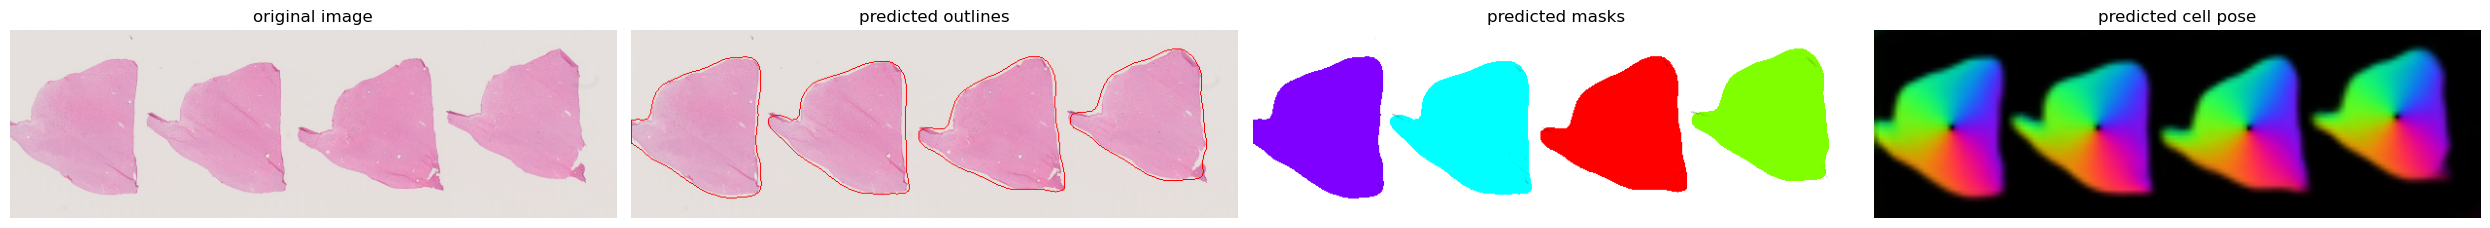

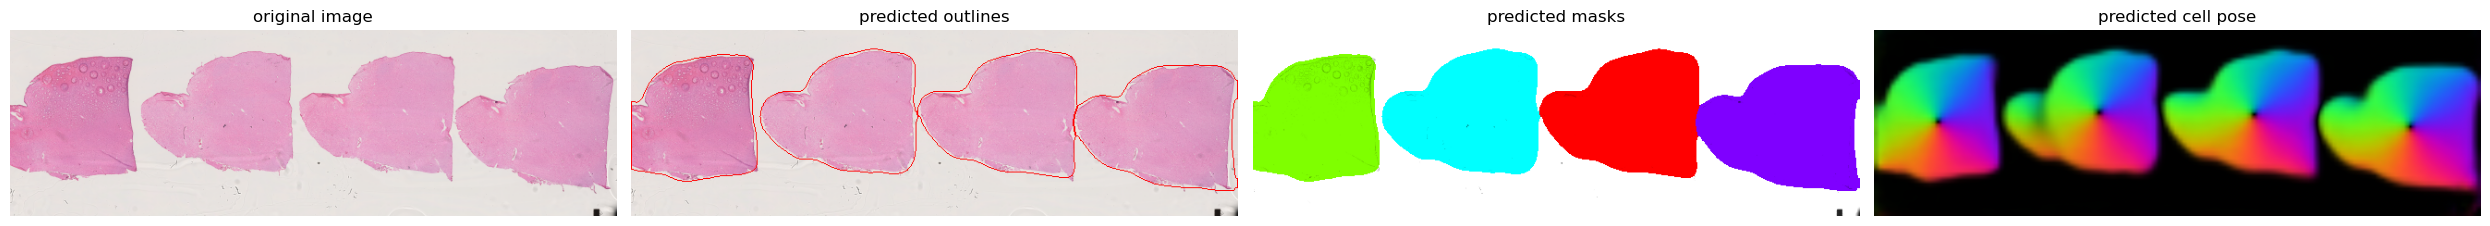

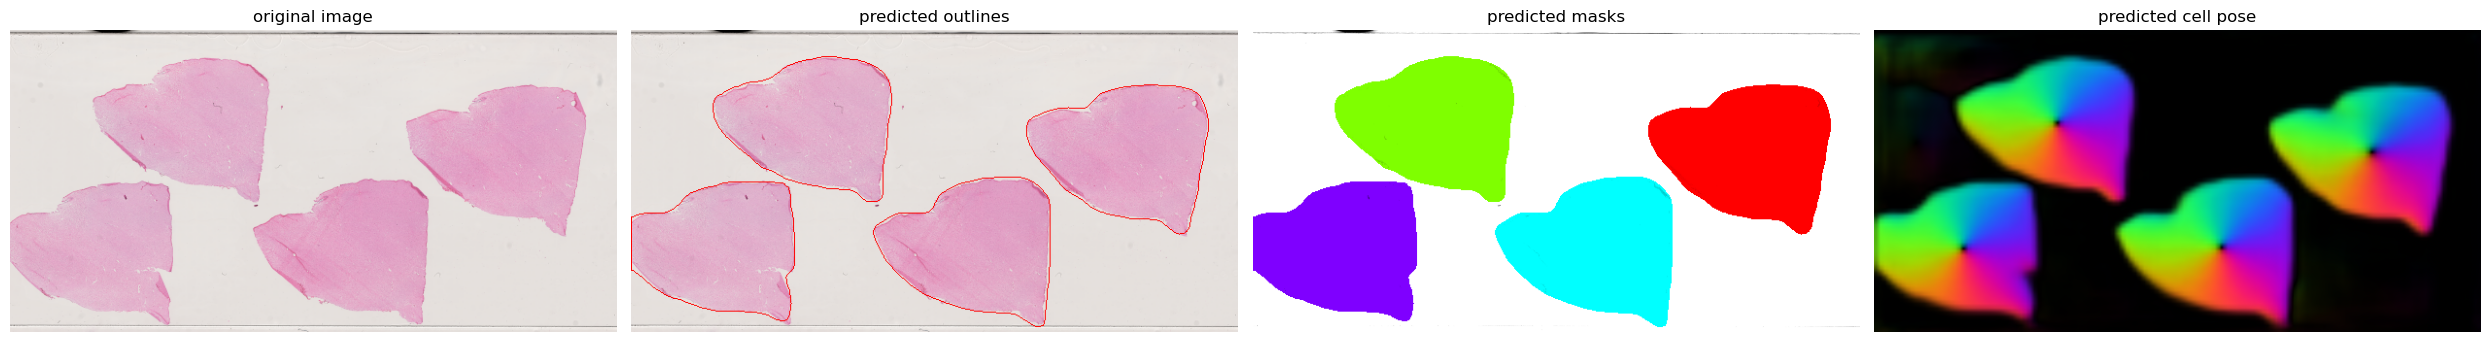

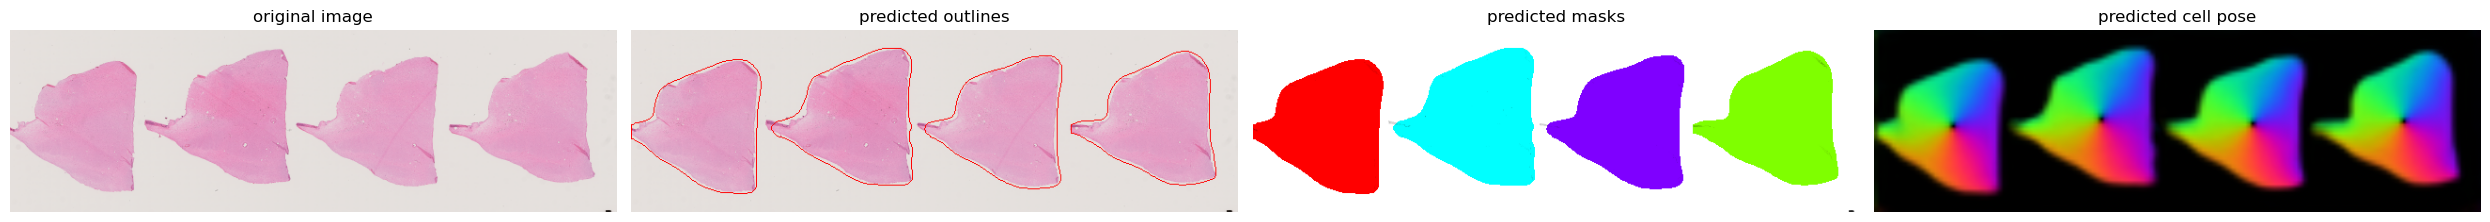

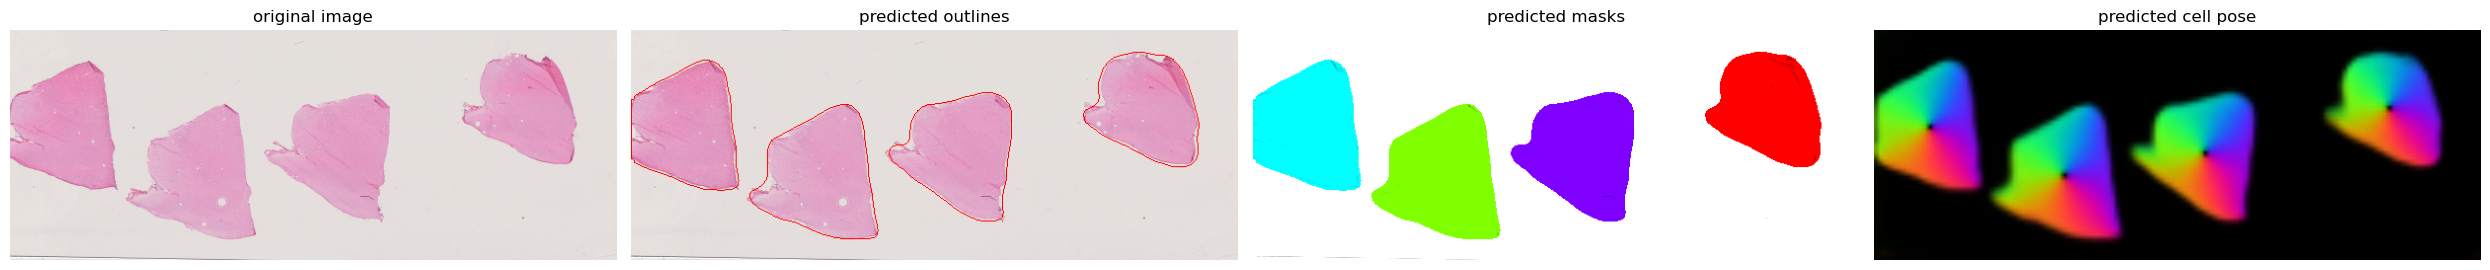

In [18]:
# TRY IT ON FEW IMAGES TO CHECK OPTIMAL CELLPOSE PARAMETERS
# Subset n evenly interspersed images
indices = np.linspace(0, len(imgs) - 1, n, dtype=int)
subset_imgs = [imgs[i] for i in indices]

# Visualize the subset images
plt.figure(figsize=(5 * n, 2 * n))

for i, img in enumerate(subset_imgs):
    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Img {indices[i]}')  # Still show the original index for reference

plt.tight_layout()
plt.show()

# Run the model on the subset images
masks, flows, styles, diams = model.eval(subset_imgs, channels=channels, diameter=diameter, cellprob_threshold=cellprob_threshold)

# Visualize the output of the model on the subset images
for i in range(len(subset_imgs)):
    fig = plt.figure(figsize=(5 * n, 2 * n))
    plot.show_segmentation(fig, subset_imgs[i], masks[i], flows[i][0], channels=channels[0])
    plt.tight_layout()
    plt.show()


In [19]:
# APPLY TO ALL IMAGES
# Run the model on all images
masks, flows, styles, diams = model.eval(imgs, channels=channels, diameter=diameter, cellprob_threshold=cellprob_threshold)

# Save masks
io.save_masks(imgs, masks, flows, img_names, png=False, tif=True, savedir=pth_masks)
print(f"Saved {len(imgs)} masks in {pth_masks}")

# Save overlaid masks
for i in range(len(imgs)):
    overlay = plot.mask_overlay(imgs[i], masks[i], colors=None)  # returns RGB overlay

    # Blend overlay and image
    alpha = 0.25
    blended = (alpha * overlay.astype(np.float32) +
               (1 - alpha) * imgs[i].astype(np.float32)).astype(np.uint8)

    # Save as TIFF
    save_path = os.path.join(pth_overlaid, os.path.splitext(img_names[i])[0] + "_overlay.tif")
    imsave(save_path, blended)
print(f"Saved {len(imgs)} overlaid masks in {pth_overlaid}")

2025-05-01 10:32:19,407 [INFO] channels set to [0, 0]
2025-05-01 10:32:19,408 [INFO] ~~~ FINDING MASKS ~~~
2025-05-01 10:32:28,339 [INFO] 100%|##########| 118/118 [00:08<00:00, 13.21it/s]
2025-05-01 10:32:28,339 [INFO] >>>> TOTAL TIME 8.93 sec
Saved 118 masks in /home/donald/Desktop/donald/data/LC_CODA/Br5417/cropped/new_tif_2_5x
Saved 118 overlaid masks in /home/donald/Desktop/donald/data/LC_CODA/Br5417/cropped/new_tif_2_5x/overlaid_masks
